<a href="https://colab.research.google.com/github/HanifAmeen/SE-44-Dermorax/blob/ML-Model-2---CNN-from-Scratch/SDGP_CNN_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting the drive

In [ ]:
#mounting the drive 
from google.colab import drive
drive.mount('/content/drive')
print("done")

Mounted at /content/drive
done


In [ ]:
!nvidia-smi

Thu Mar 24 13:16:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Imports

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import (concatenate,Dense, Conv2D, MaxPooling2D, Flatten,
                                     Input,Activation,add,BatchNormalization,Dropout)

import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#Data Preprocessing

##Initializing the dataset

In [ ]:
data_pd = pd.read_csv('/content/drive/MyDrive/Dataset/HAM10000_metadata')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [ ]:
#counting the images per each class
def count_images_on_type(series):
    display(pd.DataFrame(series.value_counts()))

#class_list = ['akiec','bcc','bkl','df','mel','nv','vasc']
count_images_on_type(data_pd['dx'])


,dx
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


In [ ]:
train_dir = os.path.join('HAM10000', 'train_dir')

test_dir = os.path.join('HAM10000', 'test_dir')


In [ ]:

#making the directories to store test and train data
os.mkdir('/content/drive/MyDrive/Dataset/train_dir')
os.mkdir('/content/drive/MyDrive/Dataset/test_dir')

In [ ]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization,dataset
lesion_id,,,,,,,
HAM_0000000,2,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1,1


In [ ]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)
df_count.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000001,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1


In [ ]:
#finding the duplicates to make sure none of these images have augmented duplicates

def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no' 
    else:
        return 'duplicate'

data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicate
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicate
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicate
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicate
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicate


In [ ]:
#framing all the meta data
df_count = data_pd[data_pd['is_duplicate'] == 'no']
print(df_count)

         lesion_id      image_id     dx dx_type   age     sex localization  \
10     HAM_0001396  ISIC_0025276    bkl   histo  55.0  female        trunk   
15     HAM_0007207  ISIC_0031326    bkl   histo  65.0    male         back   
20     HAM_0006071  ISIC_0032343    bkl   histo  70.0  female         face   
33     HAM_0005612  ISIC_0024981    bkl   histo  80.0    male        scalp   
34     HAM_0005388  ISIC_0027815    bkl   histo  80.0    male        chest   
...            ...           ...    ...     ...   ...     ...          ...   
9988   HAM_0001036  ISIC_0027588  akiec   histo  50.0  female         face   
9990   HAM_0004462  ISIC_0027334  akiec   histo  45.0    male        trunk   
9991   HAM_0001152  ISIC_0030133  akiec   histo  65.0    male         face   
10001  HAM_0000020  ISIC_0031922  akiec   histo  60.0  female         face   
10008  HAM_0001576  ISIC_0033705  akiec   histo  60.0    male         face   

            dataset is_duplicate  
10     vidir_modern         

##Test Train Split 15% to 85%

In [ ]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

In [ ]:
#labels the data as test or train
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'


In [ ]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
3232,HAM_0002773,ISIC_0028690,nv,follow_up,55.0,male,trunk,vidir_molemax,no
9424,HAM_0001009,ISIC_0029401,nv,consensus,35.0,male,foot,vidir_modern,no
6471,HAM_0003056,ISIC_0026684,nv,follow_up,40.0,female,back,vidir_molemax,no
3454,HAM_0000175,ISIC_0028356,nv,follow_up,40.0,female,lower extremity,vidir_molemax,no
4411,HAM_0001114,ISIC_0031260,nv,follow_up,75.0,male,abdomen,vidir_molemax,no


In [ ]:
#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicate,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicate,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicate,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicate,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicate,train


In [ ]:
# adding to lists by image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [ ]:
len(train_list)

9187

In [ ]:
len(test_list)

828

In [ ]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [ ]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
#making the directories per each cancer type in test and train dir 
for i in targetnames:
  os.mkdir("/content/drive/MyDrive/Dataset/test_dir/"+i)
  os.mkdir("/content/drive/MyDrive/Dataset/train_dir/"+i)

###Copying the images to the test and the train folders

In [ ]:
#compying images to train folders
for image in train_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('/content/drive/MyDrive/Dataset/HAM10000/',file_name)

    # copying the image from the source to target file
    target = os.path.join('/content/drive/MyDrive/Dataset/train_dir/',label,file_name) 

    shutil.copyfile(source, target)

In [ ]:
#copying images to the test folders
for image in test_list:

    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('/content/drive/MyDrive/Dataset/HAM10000/',file_name)

    # copying the image from the source to target file
    target = os.path.join('/content/drive/MyDrive/Dataset/test_dir/',label,file_name)

    shutil.copyfile(source, target)

##Image Augmentation

In [ ]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Augmenting images and storing them in temporary directories 
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    
    os.mkdir('/content/drive/MyDrive/Dataset/aug_dir')
    # creating a subdirectory inside the base directory for images of the same class
    
    os.mkdir('/content/drive/MyDrive/Dataset/aug_dir/img_dir')

    img_list = os.listdir('/content/drive/MyDrive/Dataset/train_dir/' + img_class)

    # Copy images from the class train_dir to the img_dir 
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('/content/drive/MyDrive/Dataset/train_dir/',img_class, file_name)

        # creating a target directory to send images 
        target = os.path.join('/content/drive/MyDrive/Dataset/aug_dir/img_dir/',file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = '/content/drive/MyDrive/Dataset/aug_dir/'

    # Augmented images will be saved to training directory
    save_path = '/content/drive/MyDrive/Dataset/train_dir/'+img_class

    # Creating Image Data Generator to augment images
    # Rotating,flipping and shifting the images to create augmented images.
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,
                                              save_to_dir=save_path,
                                              save_format='jpg',
                                              target_size=(224, 224),
                                              batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000 

    num_files = len(os.listdir('/content/drive/MyDrive/Dataset/aug_dir/img_dir/'))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory 
    shutil.rmtree('/content/drive/MyDrive/Dataset/aug_dir')


Found 304 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 109 images belonging to 1 classes.
Found 1079 images belonging to 1 classes.
Found 6042 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


In [ ]:
train_path = '/content/drive/MyDrive/Dataset/train_dir'
test_path = '/content/drive/MyDrive/Dataset/test_dir'
batch_size = 32

In [ ]:
datagen=ImageDataGenerator()

In [ ]:
#To find the total number of images in the training batch and test batch.
image_size = 299
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 51699 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.


In [ ]:
#image shape width =299 height=299 (depth=3) RGB
train_batches.image_shape

(299, 299, 3)

In [ ]:
print(train_batches.filenames)

['akiec/ISIC_0024329.jpg', 'akiec/ISIC_0024372.jpg', 'akiec/ISIC_0024418.jpg', 'akiec/ISIC_0024450.jpg', 'akiec/ISIC_0024463.jpg', 'akiec/ISIC_0024468.jpg', 'akiec/ISIC_0024470.jpg', 'akiec/ISIC_0024511.jpg', 'akiec/ISIC_0024517.jpg', 'akiec/ISIC_0024522.jpg', 'akiec/ISIC_0024539.jpg', 'akiec/ISIC_0024562.jpg', 'akiec/ISIC_0024575.jpg', 'akiec/ISIC_0024579.jpg', 'akiec/ISIC_0024646.jpg', 'akiec/ISIC_0024654.jpg', 'akiec/ISIC_0024707.jpg', 'akiec/ISIC_0024710.jpg', 'akiec/ISIC_0024763.jpg', 'akiec/ISIC_0024771.jpg', 'akiec/ISIC_0024800.jpg', 'akiec/ISIC_0024843.jpg', 'akiec/ISIC_0024913.jpg', 'akiec/ISIC_0024923.jpg', 'akiec/ISIC_0024925.jpg', 'akiec/ISIC_0024946.jpg', 'akiec/ISIC_0024948.jpg', 'akiec/ISIC_0025029.jpg', 'akiec/ISIC_0025069.jpg', 'akiec/ISIC_0025089.jpg', 'akiec/ISIC_0025130.jpg', 'akiec/ISIC_0025178.jpg', 'akiec/ISIC_0025182.jpg', 'akiec/ISIC_0025196.jpg', 'akiec/ISIC_0025247.jpg', 'akiec/ISIC_0025264.jpg', 'akiec/ISIC_0025319.jpg', 'akiec/ISIC_0025331.jpg', 'akiec/ISIC

#Model

In [ ]:
#Model Parameters
input_shape = (299, 299, 3)
num_classes = 7

#initialize a sequential model
model = Sequential()

#conv2D(num_filters, kernal(filter)_size, activation, padding, input_shape)


model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(BatchNormalization())

################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.10))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(124, (5, 5), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))
################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.10))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(124, (5, 5), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))
################


#flattening layer
model.add(Flatten())

model.add(Activation('relu'))
##

#7x7=49 all possibilities 
#model.add(Dense(49, activation='relu'))

#model.add(Dense(2401, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.10))

#Output
model.add(Dense(num_classes, activation='softmax'))

#Model Summary

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 299, 299, 32)      896       
                                                                 
 batch_normalization_24 (Bat  (None, 299, 299, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_28 (Conv2D)          (None, 299, 299, 64)      18496     
                                                                 
 batch_normalization_25 (Bat  (None, 299, 299, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 149, 149, 64)     0         
 g2D)                                                            
                                                      

#Model Evaluation Before Training

In [ ]:
batch_size=16
#taking predictions from the trained model against the test images
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

NameError: ignored

In [ ]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes



# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report BEFORE TRAINING for all 7 calsses :")
print("\n")
print(report)


Classification Report BEFORE TRAINING for all 7 calsses :


              precision    recall  f1-score   support

       akiec       0.80      0.17      0.29        23
         bcc       0.71      0.65      0.68        26
         bkl       0.39      0.35      0.37        66
          df       0.21      0.50      0.30         6
         mel       0.33      0.15      0.20        34
          nv       0.89      0.95      0.92       663
        vasc       1.00      0.70      0.82        10

    accuracy                           0.83       828
   macro avg       0.62      0.50      0.51       828
weighted avg       0.82      0.83      0.82       828



#Training the Model

In [ ]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)

#compiling the model
model.compile(optimizer = opt1 , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
checkpoint_path ='/content/drive/MyDrive/Dataset/Callbacks/CNN_CP.cpkt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    verbose=1
)

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=2, min_delta=0.001)

In [ ]:
##Loading the weights of the last training session
model.load_weights('/content/drive/MyDrive/Callbacks/CNN_CP.cpkt')

In [ ]:

#training
history = model.fit(train_batches,
                    batch_size=32,
                    epochs = 10,
                    validation_data = test_batches,
                    verbose = 1,
                    validation_steps=len(test_df)/batch_size,
                    steps_per_epoch=len(train_df)/batch_size, 
                    callbacks=[cp_callback,Earlystop])


Epoch 1/10
148/287 [==============>...............] - ETA: 55:21 - loss: 1.5708 - accuracy: 0.3961

In [ ]:
model.save('/content/drive/MyDrive/Dataset/SDGP_CNN.h5')

#Model Evaluation after Training

In [ ]:
batch_size=16
#taking predictions from the trained model against the test images
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)


In [ ]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes



# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report AFTER TRAINING for all 7 calsses :")
print(report)

#Converting the model to a TfLite model

In [ ]:
# Convert Keras model to TF Lite format using quantization.
#Quantization is the process of mapping continuous infinite values to a smaller set of discrete finite values
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpx1w6fny9/assets


INFO:tensorflow:Assets written to: /tmp/tmpx1w6fny9/assets


In [ ]:
# Show model size in MBs.
quantized_model_size = len(tflite_quantized_model) /1024/1024
print(quantized_model_size)

2.5102691650390625


In [ ]:
# Save the quantized model to files Downloads directory
f = open('SDGP_CNN_Model.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the skin cancer classification model
from google.colab import files
files.download('SDGP_CNN_Model.tflite')

print('SDGP_CNN_Model.tflite has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SDGP_CNN_Model.tflite has been downloaded


#Cancer Prediction

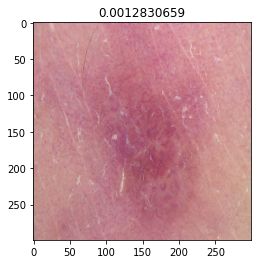

In [ ]:
image_path="/content/drive/MyDrive/Dataset/test_dir/df/ISIC_0026254.jpg"
img = image.load_img(image_path, target_size=(299, 299))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result=model.predict(img)
plt.title((result[0][6]))
plt.show()